<a href="https://colab.research.google.com/github/Akobabs/Graph-Neural-Network--GNN--based-news-recommendation-system/blob/main/NewsRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Setup and Dependencies
!pip install torch torch-geometric pandas numpy matplotlib seaborn scikit-learn
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score, roc_curve
from collections import Counter
import os
from google.colab import drive

# Mount Google Drive to access MIND dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile

zip_path = "/content/drive/MyDrive/Graph Neural Network News Recommendation/MINDsmall_train.zip"
extract_to = "/content/drive/MyDrive/Graph Neural Network News Recommendation"

# Create the extraction folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping complete!")


Unzipping complete!


In [3]:
# Update path to where you uploaded MIND-small dataset in Google Drive
news_path = '/content/drive/MyDrive/Graph Neural Network News Recommendation/news.tsv'
behaviors_path = '/content/drive/MyDrive/Graph Neural Network News Recommendation/behaviors.tsv'

news = pd.read_csv(news_path, sep='\t',
                   names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t',
                        names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

News Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   news_id            51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB
None

Behaviors Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   impression_id  156965 non-null  int64 
 1   user_id        156965 non-null  object
 2   time           156965 non-null  object
 

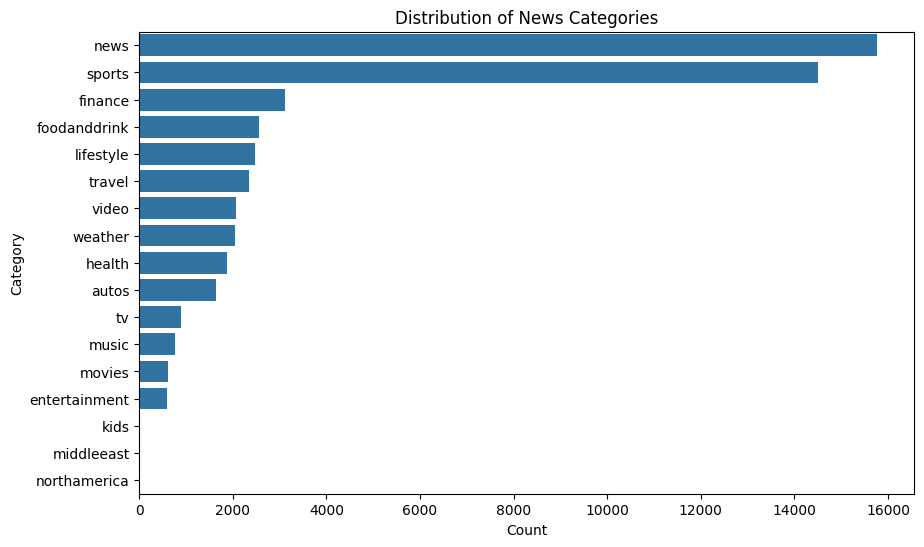

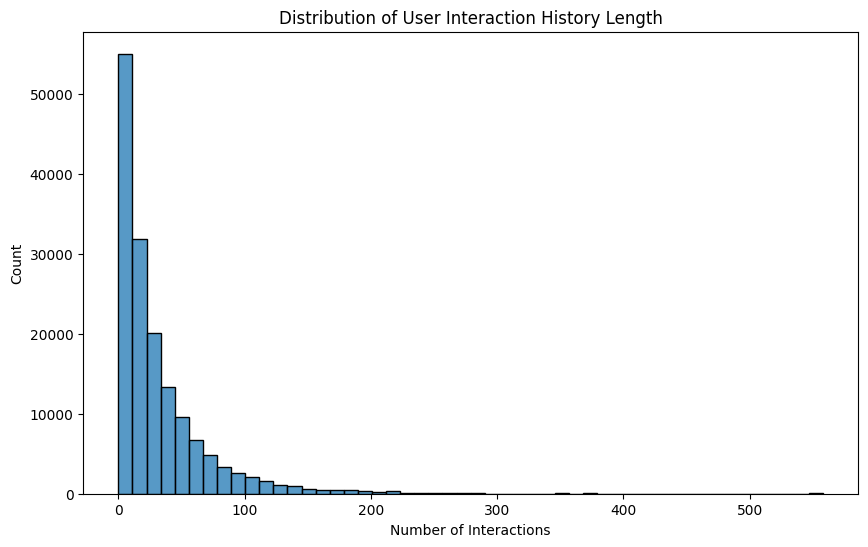

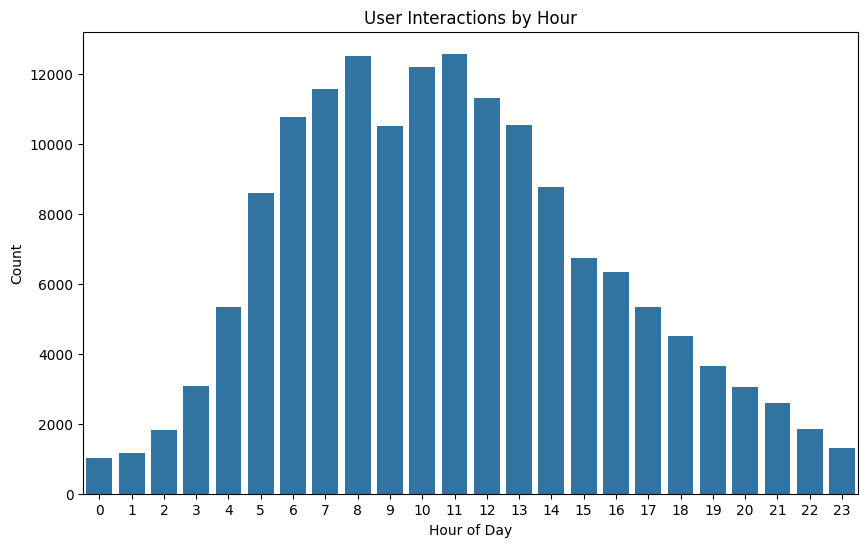

In [4]:
# Basic Statistics
print("News Data Overview:")
print(news.info())
print("\nBehaviors Data Overview:")
print(behaviors.info())

# Category Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=news['category'], order=news['category'].value_counts().index)
plt.title('Distribution of News Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# User Interaction Analysis
behaviors['history'] = behaviors['history'].fillna('').str.split()
interaction_counts = behaviors['history'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(interaction_counts, bins=50)
plt.title('Distribution of User Interaction History Length')
plt.xlabel('Number of Interactions')
plt.ylabel('Count')
plt.show()

# Temporal Analysis
behaviors['time'] = pd.to_datetime(behaviors['time'])
behaviors['hour'] = behaviors['time'].dt.hour
plt.figure(figsize=(10, 6))
sns.countplot(x=behaviors['hour'])
plt.title('User Interactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()

In [5]:
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode users and news items to integer IDs
user_encoder = LabelEncoder()
news_encoder = LabelEncoder()

behaviors_exploded = behaviors.explode('history')
user_ids = user_encoder.fit_transform(behaviors_exploded['user_id'])
news_ids = news_encoder.fit_transform(behaviors_exploded['history'])

# Build sparse interaction matrix
interaction_matrix = csr_matrix(
    (np.ones(len(user_ids)), (user_ids, news_ids)),
    shape=(len(user_encoder.classes_), len(news_encoder.classes_))
)

# Compute sparsity
num_possible = interaction_matrix.shape[0] * interaction_matrix.shape[1]
sparsity = 1 - (interaction_matrix.nnz / num_possible)

print(f"User-News Interaction Matrix Sparsity: {sparsity:.4f}")

User-News Interaction Matrix Sparsity: 0.9994


In [6]:
# 1. Create TF-IDF Features for News Titles
tfidf = TfidfVectorizer(max_features=100)
news_features = tfidf.fit_transform(news['title'].fillna('')).toarray()  # shape: (num_news, 100)

# 2. Create User Features (normalized interaction count)
user_interaction_count = behaviors.groupby('user_id').size().values.reshape(-1, 1) / 100.0  # shape: (num_users, 1)

# 3. Pad user features to match news feature dimension (100)
num_users = user_interaction_count.shape[0]
user_features_padded = np.hstack([
    user_interaction_count,
    np.zeros((num_users, news_features.shape[1] - 1))  # fill remaining 99 dims with 0
])  # shape: (num_users, 100)

# 4. Combine user and news features into node features
node_features = np.vstack([user_features_padded, news_features])  # shape: (num_users + num_news, 100)
node_features = torch.tensor(node_features, dtype=torch.float)

# 5. Create Edge Index from user-news interactions
interactions = behaviors.explode('history')[['user_id', 'history']].dropna()

# Map user IDs and news IDs to node indices
user_ids_map = {uid: i for i, uid in enumerate(behaviors['user_id'].unique())}
news_ids_map = {
    nid: i + len(user_ids_map) for i, nid in enumerate(news['news_id'].unique())
}

# Filter out histories not in the news dataset (avoid KeyError)
interactions = interactions[interactions['history'].isin(news_ids_map)]

# Convert to index form
user_ids = interactions['user_id'].map(user_ids_map).values
news_ids = interactions['history'].map(news_ids_map).values

# Create undirected edge index
edge_index = torch.tensor([user_ids, news_ids], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # shape: (2, 2 * num_edges)

# 6. Create PyG Data Object
data = Data(x=node_features, edge_index=edge_index)

<ipython-input-6-32f8bd243308>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([user_ids, news_ids], dtype=torch.long)


In [7]:
class GNNRecommender(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNRecommender, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize Model
model = GNNRecommender(in_channels=data.x.shape[1], hidden_channels=16, out_channels=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
# Split Edges for Training/Validation/Test
edge_index_train, edge_index_test = train_test_split(edge_index.t().numpy(), test_size=0.3, random_state=42)
edge_index_val, edge_index_test = train_test_split(edge_index_test, test_size=0.5, random_state=42)
edge_index_train = torch.tensor(edge_index_train, dtype=torch.long).t()
edge_index_val = torch.tensor(edge_index_val, dtype=torch.long).t()
edge_index_test = torch.tensor(edge_index_test, dtype=torch.long).t()

# Training Loop
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    out = model(data.x, edge_index_train)
    loss = F.mse_loss(out[edge_index_train[0]], out[edge_index_train[1]])
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.0013256219681352377
Epoch 2, Loss: 0.0005057002417743206
Epoch 3, Loss: 0.00018070856458507478
Epoch 4, Loss: 2.4434024453512393e-05
Epoch 5, Loss: 4.114815601496957e-05
Epoch 6, Loss: 6.486977508757263e-05
Epoch 7, Loss: 5.637385766021907e-05
Epoch 8, Loss: 3.5489701986080036e-05
Epoch 9, Loss: 1.880930722109042e-05
Epoch 10, Loss: 9.467400559515227e-06
Epoch 11, Loss: 4.969968358636834e-06
Epoch 12, Loss: 2.954615410999395e-06
Epoch 13, Loss: 2.0265276816644473e-06
Epoch 14, Loss: 1.5745554264867678e-06
Epoch 15, Loss: 1.331688508798834e-06
Epoch 16, Loss: 1.1803234656326822e-06
Epoch 17, Loss: 1.0744606697699055e-06
Epoch 18, Loss: 9.941858252204838e-07
Epoch 19, Loss: 9.29455666209833e-07
Epoch 20, Loss: 8.757934324421512e-07
Epoch 21, Loss: 8.302000651383423e-07
Epoch 22, Loss: 7.910445560810331e-07
Epoch 23, Loss: 7.569786930616829e-07
Epoch 24, Loss: 7.270853075169725e-07
Epoch 25, Loss: 7.007059252828185e-07
Epoch 26, Loss: 6.774671419407241e-07
Epoch 27, Loss:

In [9]:
def evaluate_recommendations_batched(model, data, edge_index_test, news, user_ids_map, news_ids_map, interactions, top_k=10, batch_size=50):
    model.eval()
    with torch.no_grad():
        out = model(data.x, edge_index_test)
        user_embeddings = out[:len(user_ids_map)]
        news_embeddings = out[len(user_ids_map):]

        news_id_list = list(news_ids_map.keys())
        user_to_news = interactions.groupby('user_id')['history'].apply(set).to_dict()

        y_true = []
        y_pred = []
        y_scores = []

        num_users = len(user_ids_map)
        user_ids = list(user_ids_map.keys())

        for start_idx in range(0, num_users, batch_size):
            end_idx = min(start_idx + batch_size, num_users)
            batch_user_emb = user_embeddings[start_idx:end_idx]  # shape: batch_size x emb_dim

            # Compute batch scores (batch_size x num_news)
            batch_scores = torch.matmul(batch_user_emb, news_embeddings.t())

            for i, user_idx in enumerate(range(start_idx, end_idx)):
                user_id = user_ids[user_idx]
                scores_for_user = batch_scores[i]
                top_k_indices = torch.topk(scores_for_user, k=top_k).indices
                recommended_news = [news_id_list[idx] for idx in top_k_indices.tolist()]
                actual_news = user_to_news.get(user_id, set())

                true_labels = [1 if news_id in actual_news else 0 for news_id in recommended_news]
                pred_labels = [1] * top_k

                y_true.extend(true_labels)
                y_pred.extend(pred_labels)
                y_scores.extend(scores_for_user[top_k_indices].cpu().numpy())

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        mse = mean_squared_error(y_true, y_scores)
        auc = roc_auc_score(y_true, y_scores) if len(set(y_true)) > 1 else 0.0

        return {
            f'Precision@{top_k}': precision,
            f'Recall@{top_k}': recall,
            f'F1 Score@{top_k}': f1,
            'MSE': mse,
            'ROC-AUC': auc
        }, y_true, y_scores


In [10]:
metrics, y_true, y_scores = evaluate_recommendations_batched(
    model, data, edge_index_test, news, user_ids_map, news_ids_map, interactions, top_k=10, batch_size=50
)

In [12]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Graph Neural Network News Recommendation/news_recommender_model.pth')

# Convert and save metrics
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value']).sort_values(by='Value', ascending=False)
metrics_df.to_csv('/content/drive/MyDrive/Graph Neural Network News Recommendation/evaluation_metrics.csv')
